In [1]:
pip install git+https://github.com/LIAAD/yake

  Cloning https://github.com/LIAAD/yake to /tmp/pip-req-build-alp74s7u
  Running command git clone --filter=blob:none --quiet https://github.com/LIAAD/yake /tmp/pip-req-build-alp74s7u
  Resolved https://github.com/LIAAD/yake to commit 374fc1c1c19eb080d5b6115cbb8d4a4324392e54
  Preparing metadata (setup.py) ... done
Note: you may need to restart the kernel to use updated packages.


In [2]:
!pip install rake-nltk

In [3]:
!python3 -m pip install pytextrank
!python3 -m spacy download es_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 29.1 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')


In [4]:
!pip install setfit

In [2]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /home/sergi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/sergi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
import os, re
from nltk.tokenize import word_tokenize

import nltk

from rake_nltk import Rake

import yake

import spacy, pytextrank

In [4]:
class Extractor:
    def __init__(self, language, max_tokens):
        self.language = language
        self.max_tokens = max_tokens
        pass

    def extract_terms(self, text):
        raise NotImplementedError("extract_terms method must be implemented in subclass")

    def extract_terms_with_span(self, text):
        terms = self.extract_terms(text)
        terms_with_span = self.find_term_span(text, terms)
        return terms_with_span

    def extract_terms_without_overlaps(self, text):
        terms_with_span = self.extract_terms_with_span(text)
        terms_without_overlaps = self.rmv_overlaps(terms_with_span)
        return terms_without_overlaps

    def postprocess_terms(self, terms):
        new_terms = self.rmv_meaningless(terms)
        new_terms = self.rmv_stopwords(new_terms)
        new_terms = self.rmv_stopwords(new_terms)
        new_terms = self.rmv_nonalnum_characters(new_terms)
        new_terms = self.rmv_nonalnum_characters(new_terms)
        new_terms = self.rmv_meaningless(new_terms)
        return new_terms

    def rmv_meaningless(self, terms):
        self.stopwords = nltk.corpus.stopwords.words(self.language)
        new_terms = [t for t in terms if (t[0] not in self.stopwords and len(t[0]) >= 2 and not t[0].isdigit())]
        return new_terms

    def rmv_stopwords(self, terms):
        new_terms = terms
        self.stopwords = nltk.corpus.stopwords.words(self.language)
        for word in self.stopwords:
            new_terms = [(t[0][(len(word)+1):], t[1] + len(word) + 1, t[2], t[3], t[4]) if (t[0].lower().startswith(word.lower() + " ")) else t for t in new_terms]
            new_terms = [(t[0][:-(len(word)+1)], t[1], t[2] - len(word) - 1, t[3], t[4]) if (t[0].lower().endswith(" " + word.lower())) else t for t in new_terms]
        return new_terms

    def rmv_nonalnum_characters(self, terms):
        new_terms = [(t[0][1:], t[1] + 1, t[2], t[3], t[4]) if not t[0][0].isalnum() else t for t in terms]
        new_terms = [(t[0][:-1], t[1], t[2] - 1, t[3], t[4]) if not t[0][-1].isalnum() else t for t in new_terms]
        return new_terms

    @staticmethod
    def find_term_span(text, terms):
        spans = []
        for t,score in terms:
          term = re.escape(t)
          patron = r'\b' + term + r'\b'
          coincidencias = re.finditer(patron, text, re.IGNORECASE)
          span = [(t, coincidencia.start(), coincidencia.end()-1, score) for coincidencia in coincidencias]
          spans.extend(span)
        return spans

    @staticmethod
    def rmv_overlaps(keywords):
      ent = [kw[0] for kw in keywords]
      pos = [kw[1:3] for kw in keywords]
      score = [kw[3:] for kw in keywords]
      updated_keywords = []
      repeated_words = []
      for i in range(len(ent)):
        overlap = False
        if pos[i] in repeated_words:
          overlap = True
        else:
          repeated_words.append(pos[i])
          for k in range(len(ent)):
            if (((pos[i][0] >= pos[k][0]) and (pos[i][1] < pos[k][1])) or ((pos[i][0] > pos[k][0]) and (pos[i][1] <= pos[k][1]))):
              overlap = True
        if (not overlap):
          kw = (ent[i],pos[i][0],pos[i][1]) + score[i]
          updated_keywords.append(kw)
      return updated_keywords

In [5]:
class RakeExtractor(Extractor):
    def __init__(self, language, max_tokens):
        super().__init__(language, max_tokens)
        self.stopwords = nltk.corpus.stopwords.words(language)
        self.extractor = Rake(stopwords=self.stopwords, language=language)

    def extract_terms(self, text):
        self.extractor.extract_keywords_from_text(text)
        terms = self.extractor.get_ranked_phrases_with_scores()
        terms = [(kw,score) for score,kw in terms if (len(word_tokenize(kw, language=self.language)) <= self.max_tokens)]
        return terms

In [6]:
class YakeExtractor(Extractor):
    def __init__(self, language, max_tokens):
        super().__init__(language, max_tokens)
        if language=='spanish':
            self.extractor = yake.KeywordExtractor() #aqui habria que poner top=70 por ejemplo
        else:
            raise ValueError("Expected spanish language. Other languages not recognised")

    def extract_terms(self, text):
        keywords = self.extractor.extract_keywords(text)
        terms = [(kw,score) for kw, score in keywords if (len(word_tokenize(kw)) <= self.max_tokens)]
        return terms

In [7]:
class TextRankExtractor(Extractor):
    def __init__(self, language, max_tokens):
        super().__init__(language, max_tokens)
        if language=='spanish':
            self.extractor = spacy.load("es_core_news_sm")
            self.extractor.add_pipe("textrank")
        else:
            raise ValueError("Expected spanish language. Other languages not recognised")

    def extract_terms(self, text):
        doc = self.extractor(text)
        terms = []
        for phrase in doc._.phrases:
          if (len(word_tokenize(phrase.text)) <= self.max_tokens):
            terms.append((phrase.text, phrase.rank))
        return terms

In [58]:
class TermExtractor:
    def __init__(self, extraction_methods=["textrank"], categorizer_method="setfit", language="spanish", max_tokens=3, join=False, postprocess=True, parents=False, n=1, threshold=0.5):
        self.extraction_methods = extraction_methods
        self.extractors = self.initialize_keyword_extractors(language, max_tokens)
        self.categorizer_method = categorizer_method
        self.categorizer = self.initialize_categorizers(parents, n, threshold)
        self.join = join
        self.postprocess = postprocess

    #def __init__(self, **kwargs):
    #    for key, value in kwargs.items():
    #		setattr(self, key, value)
    
    def __call__(self, text):
        self.extract_terms(text, self.join, self.postprocess)
        self.categorize_terms()
        
    def initialize_keyword_extractors(self, language, max_tokens):
        keyword_extractors = {} #esto esta hecho para mas de un extractor a la vez???
        
        if 'rake' in self.extraction_methods:
            keyword_extractors["rake"] = RakeExtractor(language, max_tokens)
        
        if 'yake' in self.extraction_methods:
            keyword_extractors["yake"] = YakeExtractor(language, max_tokens)
        
        if 'textrank' in self.extraction_methods:
            keyword_extractors["textrank"] = TextRankExtractor(language, max_tokens)

        if not keyword_extractors:
            raise ValueError("No extraction method called {}".format(self.extraction_methods))
        
        return keyword_extractors

    def extract_terms(self, text, join, postprocess):
        try:
            all_terms = []
            for key, extractor in self.extractors.items():
                terms = extractor.extract_terms_without_overlaps(text)
                terms = [term + (key,) for term in terms]
                all_terms.extend(terms)
            if join:
                all_terms = list(self.extractors.values())[0].rmv_overlaps(all_terms)
            if postprocess:
                all_terms = list(self.extractors.values())[0].postprocess_terms(all_terms)
            self.keywords = [Keyword(text=i[0], method=i[4], ini=i[1], fin=i[2], score=i[3]) for i in all_terms]
        except:
            raise AttributeError("A list of extractors must be provided")

    def initialize_categorizers(self, parents, n, threshold):
        if 'standard' == self.categorizer_method:
            categorizer = StandardClassifier()
            
        elif 'setfit' == self.categorizer_method:
            categorizer = SetFitClassifier(parents, n, threshold)

        elif 'clustering' == self.categorizer_method:
            categorizer = Clustering()

        else:
            raise ValueError("No categorizer method called {}".format(self.categorizer_method))
        return categorizer

    def categorize_terms(self):
        try:
            if self.categorizer_method == 'clustering':
                clusters = self.categorizer.compute_clusters(self.keywords)
                for kw in self.keywords:
                    kw.label = clusters[kw.text]
            else:
                for kw in self.keywords:
                    kw.label = self.categorizer.compute_predictions(kw.text)
        except:
            raise AttributeError("A categorizer method must be provided")

    def train_classifier(self, trainset, testset, mcm=False, classification_report=False):
        self.categorizer.model = self.categorizer.initialize_model_body()
        metrics = self.categorizer.train_evaluate(trainset, testset, mcm, classification_report)
        print(metrics)
        pass

In [38]:
class Keyword:
    def __init__(self, text, method, ini, fin, score):
        self.text = text
        self.method = method
        self.score = score
        self.span = [ini, fin]

    def __repr__(self):
        return f"<Keyword(text='{self.text}', method='{self.method}', score='{self.score}', span='{self.span}', class='{self.label}')>"

In [10]:
from sklearn.preprocessing import MultiLabelBinarizer

In [53]:
import evaluate
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, precision_recall_fscore_support, confusion_matrix
from collections import Counter

In [59]:
class Categorizer:
    def __init__(self):
        pass

    def evaluate_model(self, y_pred, y_test, mcm, classification_report): #els mcmc i class report default no van aqui NO HO FA AIXI
        if classification_report:
            self.classification_report(y_pred, y_test)
        if mcm:
            self.mcm_heatmap(y_pred, y_test)
        return self.compute_metrics(y_pred, y_test)

    def lambda_evaluate_model(self, mcm, classification_report):
        return lambda y_pred, y_test: self.evaluate_model(y_pred, y_test, mcm, classification_report)

    def compute_metrics(self, y_pred, y_test):
        multilabel_f1_metric = evaluate.load("f1", "multilabel")
        multilabel_accuracy_metric = evaluate.load("accuracy", "multilabel")
        f1 = multilabel_f1_metric.compute(predictions=y_pred, references=y_test, average="micro")["f1"]
        accuracy = multilabel_accuracy_metric.compute(predictions=y_pred, references=y_test)["accuracy"]

        y_pred = np.array(y_pred)
        y_test = np.array(y_test)
        
        no_label_samples = []
        for idx, pred in enumerate(y_pred):
            if np.all(pred == 0):
                true_labels = [self.labels[i] for i, value in enumerate(y_test[idx]) if value == 1]
                no_label_samples.extend(true_labels)
    
        label_counts = Counter(no_label_samples)
        label_counts_dict = dict(label_counts)
        return {"f1": f1, "accuracy": accuracy, "Classes with no given label": label_counts_dict}

    def classification_report(self, y_pred, y_test):
        y_pred = np.array(y_pred)
        y_test = np.array(y_test)

        print(classification_report(y_test, y_pred, target_names=self.labels))
        pass

    def mcm_heatmap(self, y_pred, y_test):
        y_pred = np.array(y_pred)
        y_test = np.array(y_test)
        
        samples_with_predictions = np.any(y_pred, axis=1)
    
        # Filter y_pred and y_test to include only samples with predictions
        y_pred_with_predictions = y_pred[samples_with_predictions]
        y_test_with_predictions = y_test[samples_with_predictions]
    
        # Initialize the confusion matrix
        confusion_matrix_multi = confusion_matrix(y_test_with_predictions.argmax(axis=1), y_pred_with_predictions.argmax(axis=1), labels=np.arange(len(self.labels)))
    
        # Create a heatmap-style visualization
        plt.figure(figsize=(10, 7))
        plt.imshow(confusion_matrix_multi, interpolation="nearest", cmap=plt.cm.Blues)
        plt.title("Multi-Label Confusion Matrix")
        plt.colorbar()
    
        # Label the axes
        tick_marks = np.arange(len(self.labels))
        plt.xticks(tick_marks, self.labels, rotation=45)
        plt.yticks(tick_marks, self.labels)
    
        # Display the values inside the cells
        for i in range(len(self.labels)):
            for j in range(len(self.labels)):
                plt.text(j, i, str(confusion_matrix_multi[i, j]), ha="center", va="center", color="white" if confusion_matrix_multi[i, j] > confusion_matrix_multi.max() / 2 else "black")
    
        plt.tight_layout()
        plt.ylabel("True Labels")
        plt.xlabel("Predicted Labels")
        plt.show()
        pass

In [13]:
from setfit import SetFitModel, SetFitTrainer
import torch

In [14]:
import pandas as pd
from datasets import Dataset

In [60]:
class SetFitClassifier(Categorizer):
    def __init__(self, parents, n, threshold):
        self.parents = parents
        self.n = n
        self.threshold = threshold
        self.model = self.initialize_pretrained_model()
        self.labels = ['ACTIVIDAD', 'COMUNIDAD', 'DEPARTAMENTO', 'ENFERMEDAD', 'FAC_GEN','FAC_NOM', 'FARMACO', 'GEO_GEN', 'GEO_NOM', 'GPE_GEN', 'GPE_NOM','HUMAN', 'IDIOMA', 'MORFOLOGIA_NEOPLASIA', 'NO_CATEGORY','PROCEDIMIENTO', 'PROFESION', 'SINTOMA', 'SITUACION_LABORAL','SPECIES', 'TRANSPORTE']
        
    def initialize_pretrained_model(self):
        if self.parents:
            path = '/mnt/c/Users/Sergi/Desktop/BSC/modelos_entrenados/parents_sp'
        else:
            path = '/mnt/c/Users/Sergi/Desktop/BSC/modelos_entrenados/noparents_sp'
        model = SetFitModel.from_pretrained(path)
        return model

    def compute_predictions(self, mention):
        embeddings = self.model.model_body.encode([mention], normalize_embeddings=self.model.normalize_embeddings, convert_to_tensor=True)
        predicts = self.model.model_head.predict_proba(embeddings)
        predscores = {self.labels[i]: arr[:,1].tolist()[0] for i, arr in enumerate(predicts)}
        top_n_labels = sorted(predscores, key=predscores.get, reverse=True)[:self.n]
        filtered_labels = [label for label in top_n_labels if predscores[label] > self.threshold]
        return filtered_labels

    def initialize_model_body(self):
        if self.parents:
            path = '/mnt/c/Users/Sergi/Desktop/BSC/spanish_sapbert_models/sapbert_15_parents_1epoch'
        else:
            path = '/mnt/c/Users/Sergi/Desktop/BSC/spanish_sapbert_models/sapbert_15_noparents_1epoch'
        model = SetFitModel.from_pretrained(path, multi_target_strategy="multi-output")
        return model

    #Im doing it as if I received a dataframe with the samples in columns called "text" and "label"
    def train_evaluate(self, trainset, testset, mcm, classification_report):
        train_dataset, test_dataset = self.prepare_data(trainset, testset)
        evaluate_with_params = self.lambda_evaluate_model(mcm, classification_report)
        trainer = SetFitTrainer(model=self.model, train_dataset=train_dataset, eval_dataset=test_dataset, metric=evaluate_with_params, num_iterations=5)
        #no hi ha mcm ni class report
        trainer.train()
        metrics = trainer.evaluate()
        return metrics

    def prepare_data(self, trainset, testset):
        trainY=[]
        testY=[]
        for index, row in trainset.iterrows():
            trainY.append({row["label"]})
        for index, row in testset.iterrows():
            testY.append({row["label"]})
        mlb = MultiLabelBinarizer()
        mlb.fit_transform(trainY)
        self.labels = [i for i in mlb.classes_]
        train_dataset = Dataset.from_dict({"text": trainset['text'], "label": mlb.fit_transform(trainY)})
        test_dataset = Dataset.from_dict({"text": testset['text'], "label": mlb.fit_transform(testY)})
        return train_dataset, test_dataset

In [16]:
from nltk.metrics import distance
import scipy.spatial as spatial
import numpy as np
from scipy.cluster.vq import kmeans

In [61]:
class Clustering(Categorizer):
    def __init__(self):
        self.num_labels = 16

    def compute_clusters(self, keywords):
        word_with_cluster = {}
        words = [kw.text for kw in keywords]
        word_vectors = np.array([
            [
                distance.edit_distance(w, _w)
                for _w in words
            ]
            for w in words
        ], dtype=float)
        
        centroids, _ = kmeans(word_vectors, k_or_guess=min(len(words),self.num_labels))
        
        word_clusters = np.argmin([
            [spatial.distance.euclidean(wv, cv) for cv in centroids]
            for wv in word_vectors
        ], 1)
        
        for i in range(len(words)):
            word_with_cluster[words[i]] = word_clusters[i]
        return word_with_cluster

In [62]:
extractor = TermExtractor(extraction_methods=["textrank"],categorizer_method="setfit")

/mnt/c/Users/Sergi/Documents/BioTermCategorizer/.env_biotermcategorizer/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.2.2 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/mnt/c/Users/Sergi/Documents/BioTermCategorizer/.env_biotermcategorizer/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator MultiOutputClassifier from version 1.2.2 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [44]:
file_path = '/mnt/c/Users/Sergi/Desktop/BSC/traindata_classification.tsv'
traindata = pd.read_csv(file_path, sep='\t')
traindata = traindata.sample(frac=1, random_state=42)
traindata_head = traindata.head(100)
traindata_head = traindata_head[traindata_head["label"].isin(["SINTOMA","ENFERMEDAD","SINTOMA","PROCEDIMIENTO"])]

file_path = '/mnt/c/Users/Sergi/Desktop/BSC/testdata_classification.tsv'
testdata = pd.read_csv(file_path, sep='\t')
testdata = testdata.sample(frac=1, random_state=42)
testdata_head = testdata.head(30)
testdata_head = testdata_head[testdata_head["label"].isin(["SINTOMA","ENFERMEDAD","SINTOMA","PROCEDIMIENTO"])]

traindata_head

,filename,label,text,span
6990,es-S0365-66912007001100010-1,ENFERMEDAD,retinotoxicidad por vigabatrina,"1100, 1131"
6429,es-S0004-06142009000100014-1,ENFERMEDAD,metástasis ganglionares retroperitoneales,"736, 777"
42699,es-S1139-76322014000500014-1,PROCEDIMIENTO,RM craneal,"1202, 1212"
49097,es-S0211-69952015000100013-1,SINTOMA,Doppler de arterias renales y el ecocardiogram...,"2104, 2177"
5428,es-S1699-695X2015000100013-1,ENFERMEDAD,MAVD,"1596, 1600"
54130,es-S0211-69952017000200225-2,SINTOMA,ferritina y saturación de transferan normales,"338, 383"
40368,es-S0212-71992007000300007-1,PROCEDIMIENTO,exploración física,"561, 579"
53338,es-S1131-57682003000400014-1,SINTOMA,"ganglios linfáticos, siendo los 25 negativos p...","1886, 1953"
52028,es-S0210-48062009000600016-1,SINTOMA,sangrado,"402, 410"
40126,es-S1130-01082007000600012-1,PROCEDIMIENTO,biopsia de médula ósea,"2138, 2160"


No sentence-transformers model found with name /mnt/c/Users/Sergi/Desktop/BSC/spanish_sapbert_models/sapbert_15_noparents_1epoch. Creating a new one with MEAN pooling.
model_head.pkl not found in /mnt/c/Users/Sergi/Desktop/BSC/spanish_sapbert_models/sapbert_15_noparents_1epoch, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
Generating Training Pairs: 100%|█████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 191.59it/s]
***** Running training *****
  Num examples = 420
  Num epochs = 1
  Total optimization steps = 27
  Total train batch size = 16
Epoch: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [01:51<00:00, 111.63s/it]
***** Running evaluation *****


Classification Report:
                Precision  Recall     F1-Score   Support   
ENFERMEDAD      0.00       0.00       0.00       3         
PROCEDIMIENTO   1.00       1.00       1.00       7         
SINTOMA         0.83       0.83       0.83       6         
Macro Avg       0.61       0.61       0.61       16        
Weighted Avg    0.75       0.75       0.75       16        


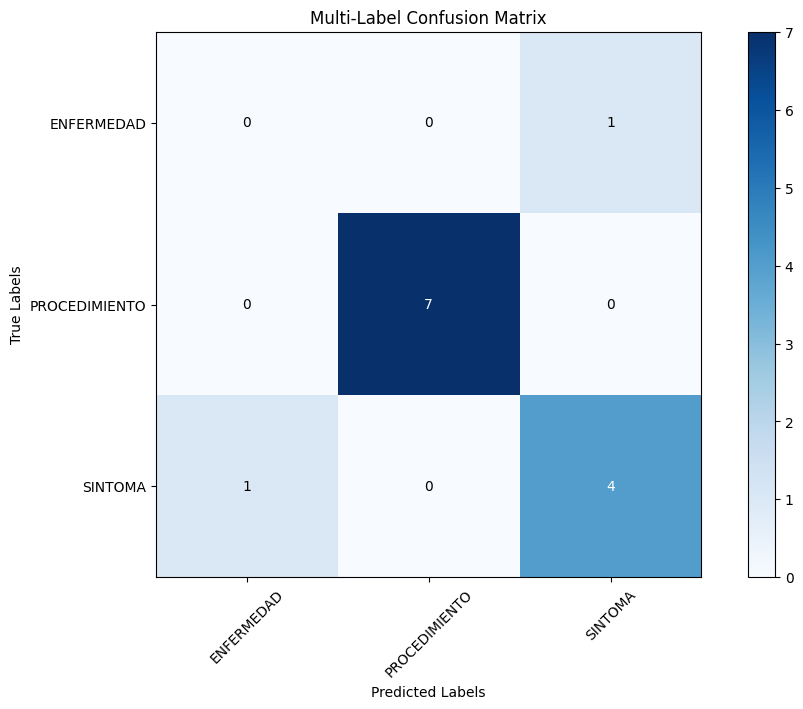

{'f1': 0.7999999999999999, 'accuracy': 0.6875, 'Classes with no given label': {'ENFERMEDAD': 2, 'SINTOMA': 1}}


In [63]:
extractor.train_classifier(traindata_head,testdata_head,mcm=True,classification_report=True)

In [64]:
extractor("La importancia vital de la esterilización de las manos antes de una laparoscopia es esencial si hay gripe")

In [65]:
extractor.keywords

[<Keyword(text='gripe', method='textrank', score='0.2795984421205809', span='[100, 104]', class='['SINTOMA']')>,
 <Keyword(text='importancia vital', method='textrank', score='0.09206970100819285', span='[3, 19]', class='[]')>,
 <Keyword(text='laparoscopia', method='textrank', score='0.08772274252666795', span='[68, 79]', class='['PROCEDIMIENTO']')>,
 <Keyword(text='manos', method='textrank', score='0.08182759864003777', span='[49, 53]', class='[]')>,
 <Keyword(text='esterilización', method='textrank', score='0.07223214099675339', span='[27, 40]', class='['PROCEDIMIENTO']')>]

In [ ]:
#estaria be fer el post processing abans de rmv_overlaps perq aixi les que passen a ser insignificants despres del postprocessing les eliminem

In [19]:
#Test de extracción completa directa
text = "Un varón de 32 años acude al Servicio de Urgencias por disminución reciente de visión en OD coincidiendo con la aparición de una lesión parduzca en dicho ojo. Entre los antecedentes oftalmológicos destaca un traumatismo penetrante en OD tres años antes que fue suturado en nuestro centro. A la exploración presenta una agudeza visual de 0,1 que mejora a 0,5 con estenopéico."

extractor1 = TermExtractor(extraction_methods="textrank", language="spanish", max_tokens=5)
print("Usando TextRank y un máximo de 5 tokens: \n",extractor1(text))

extractor2 = TermExtractor(extraction_methods=["rake", "yake"], language="spanish", max_tokens=2)
print("\nUsando Rake y Yake juntos y un máximo de 2 tokens: \n",extractor2(text))

extractor3 = TermExtractor(extraction_methods=["rake", "yake", "textrank"], language="spanish", max_tokens=3)
print("\nUsando Rake, Yake y TextRank juntos y un máximo de 3 tokens: \n",extractor3(text))

Usando TextRank y un máximo de 5 tokens: 
 None

Usando Rake y Yake juntos y un máximo de 2 tokens: 
 None

Usando Rake, Yake y TextRank juntos y un máximo de 3 tokens: 
 None


In [14]:
#Test de extracción por pasos: vemos que da lo mismo que el de antes
extractor = TermExtractor(extraction_methods="textrank", language="spanish", max_tokens=3)
terms = extractor.extractors["textrank"].extract_terms(text)
terms_with_span = extractor.extractors["textrank"].find_term_span(text,terms)
terms_without_overlaps = extractor.extractors["textrank"].rmv_overlaps(terms_with_span)
print(terms_without_overlaps)

[('dicho ojo', 148, 156), ('disminución reciente', 55, 74), ('OD', 89, 90), ('OD', 234, 235), ('estenopéico', 362, 372), ('visión', 79, 84), ('una lesión parduzca', 125, 143), ('Servicio de Urgencias', 29, 49), ('un traumatismo penetrante', 205, 229), ('nuestro centro', 273, 286), ('una agudeza visual', 315, 332), ('la aparición', 109, 120), ('32 años', 12, 18), ('tres años', 237, 245), ('los antecedentes oftalmológicos', 165, 195), ('Un varón', 0, 7), ('A la exploración', 289, 304), ('que', 253, 255), ('que', 341, 343)]


In [17]:
extractor.extractors["rake"].extract_terms("La importancia vital de lavarse con jabón las manos antes de operar es indispensable")

['importancia vital', 'operar', 'manos', 'lavarse', 'jabón', 'indispensable']

In [ ]:
extractor_terminos = TermExtractor(sadasdasdsa)

In [ ]:
doc1_terms = extractor_terminos("textoasdasdasdsa")

In [ ]:
doc1_terms.zº

In [20]:
import sys, os, re
general_path = os.getcwd().split("BioTermCategorizer")[0]+"BioTermCategorizer/"
sys.path.append(general_path+'biotermcategorizer/')


In [36]:
from TermExtractor import TermExtractor

In [37]:
extractor = TermExtractor(extraction_methods=["textrank","rake"])

In [20]:
#sample texts
text1 = "Paciente varón de 35 años con tumoración en polo superior de teste derecho hallada de manera casual durante una autoexploración, motivo por el cual acude a consulta de urología donde se realiza exploración física, apreciando masa de 1cm aproximado de diámetro dependiente de epidídimo, y ecografía testicular, que se informa como lesión nodular sólida en cabeza de epidídimo derecho. Se realiza RMN. Confirmando masa nodular, siendo el tumor adenomatoide de epidídimo la primera posibilidad diagnóstica. Se decide, en los dos casos, resección quirúrgica de tumoración nodular en cola epidídimo derecho, sin realización de orquiectomía posterior. En ambos casos se realizó examen anátomopatológico de la pieza quirúrgica. Hallazgos histológicos macroscópicos: formación nodular de 1,5 cms (caso1) y 1,2 cms (caso 2) de consistencia firme, coloración blanquecina y bien delimitada. Microscópicamente se observa proliferación tumoral constituida por estructuras tubulares en las que la celularidad muestra núcleos redondeados y elongados sin atipia citológica y que ocasionalmente muestra citoplasmas vacuolados, todo ello compatible con tumor adenomatoide de epidídimo."
text2 = "Dos recién nacidos, varón y hembra de una misma madre y fallecidos a los 10 y 45 minutos de vida respectivamente a los que se les realizó examen necrópsico. El primero de los cadáveres, correspondiente a la hembra, fue remitido con el juicio clínico de insuficiencia respiratoria grave con sospecha de Síndrome de Potter con la constatación de oligoamnios severo; nació mediante cesárea urgente por presentación de nalgas y el test de Apgar fue 1/3/7; minutos más tarde falleció. El examen externo permitió observar una tonalidad subcianótica, facies triangular con hendiduras parpebrales mongoloides, micrognatia, raiz nasal ancha y occipucio prominente. El abdomen, globuloso, duro y ligeramente abollonado permitía la palpación de dos grandes masas ocupando ambas fosas renales y hemiabdomenes. A la apertura de cavidades destacaba la presencia de dos grandes masas renales de 10 x 8 x 5,5 cm y 12 x 8 x 6 cm con pesos de 190 y 235 gr respectivamente. Si bien se podía discernir la silueta renal, la superficie, abollonada, presentaba numerosas formaciones quísticas de contenido seroso; al corte dichos quistes mostraban un tamaño heterogéneo siendo mayores los situados a nivel cortical, dando al riñón un aspecto de esponja. Los pulmones derecho e izquierdo pesaban 17 y 15 gr (peso habitual del conjunto de 49 gr) mostrando una tonalidad rojiza uniforme; ambos se encontraban comprimidos como consecuencia de la elevación diafragmática condicionada por el gran tamaño de los riñones. El resto de los órganos no mostraba alteraciones macroscópicas significativas salvo las alteraciones posicionales derivadas de la compresión renal. En el segundo de los cadáveres, el correspondiente al varón, se observaron cambios morfológicos similares si bien el tamaño exhibido por los riñones era aún mayor, con pesos de 300 y 310 gr. El resto de las vísceras abdominales estaban comprimidas contra el diafragma. En ambos casos se realizó un estudio histológico detallado, centrado especialmente en los riñones en los que se demostraron múltiples quistes de distintos tamaños con morfología sacular a nivel cortical. Dichos quistes ocupaban la mayor parte del parénquima corticomedular si bien las zonas conservadas no mostraban alteraciones significativas salvo inmadurez focal. Dichos quistes estaban tapizados por un epitelio simple que variaba desde plano o cúbico. Los quistes medulares, de menor tamaño y más redondeados estaban tapizados por un epitelio de predominio cúbico. Después de las renales, las alteraciones más llamativas se encontraban en el hígado donde se observaron proliferación y dilatación, incluso quística, de los ductos biliares a nivel de los espacios porta. Con tales hallazgos se emitió en ambos casos el diagnóstico de enfermedad poliquística renal autosómica recesiva infantil."
text3 = "Paciente de 64 años, alérgico a penicilina y con recambio valvular aórtico por endocarditis que consultó por aparición de masa peneana de crecimiento progresivo en las últimas semanas. A la exploración física destacaba una formación excrecente y abigarrada en glande, que deformaba meato, con áreas ulceradas cubiertas de fibrina. Se palpaban adenopatías fijas y duras en ambas regiones inguinales. La radiografía de tórax y el TAC abdomino-pélvico confirmaron la presencia de adenopatías pulmonares e inguinales de gran tamaño. Con el diagnóstico de neoplasia de pene, se practicó penectomía parcial con margen de seguridad. La anatomía patológica demostró que se trataba de un sarcoma pleomórfico de pene con diferenciación osteosarcomatosa y márgenes libres de afectación. Se decidió tratamiento con dos líneas de quimioterapia consistente en adriamicina e ifosfamida pero no hubo respuesta. Ingresó de nuevo con recidiva local sangrante de gran tamaño y crecimiento rápido que provocaba obstrucción de meato con insuficiencia renal aguda. Se colocó sonda de cistostomía y se instauró tratamiento con sueroterapia, mejorando la función renal, pero con empeoramiento progresivo del estado general hasta que falleció a los 6 meses del diagnóstico."
text4 = "Mujer de 28 años sin antecedentes de interés que consultó por síndrome miccional con polaquiuria de predominio diurno y cierto grado de urgencia sin escapes urinario. El urocultivo resultó negativo por lo que se indicó tratamiento con anticolinérgicos. Ante la falta de respuesta al tratamiento, se realizó cistografía que fué normal y ecografía renovesical en la que se apreciaban imágenes quísticas parapiélicas, algunas de ellas con tabiques internos y vejiga sin lesiones. Con el fin de precisar la naturaleza de dichos quistes se solicitó TAC-abdominal, que informaba de gran quiste parapiélico en riñón derecho sin repercusión sobre la vía y una masa hipodensa suprarrenal derecha. La resonancia magnética demostró normalidad de la glándula suprarrenal y una lesión quística lobulada conteniendo numerosos septos en su interior que rodeaba al riñón derecho; en la celda renal izquierda existía una lesión de características similares pero de menor tamaño. Los hallazgos eran compatibles con linfangioma renal bilateral. Tras tres años de seguimiento la paciente continua con leve síntomatologia miccional en tratamiento, pero no ha presentado síntomas derivados de su lesión renal."
text5 = "Varón de 68 años, con antecedentes de hemorragia digestiva alta por aspirina y accidente isquémico transitorio a tratamiento crónico con trifusal (300 mg cada 12 horas), que acudió al Servicio de Urgencias del Hospital San Agustín (Avilés, Asturias), en mayo de 2006, por dolor en hemiabdomen izquierdo, intenso, continuo, de instauración súbita y acompañado de cortejo vegetativo. A la exploración presentaba una tensión arterial de 210/120 mm Hg, una frecuencia cardíaca de 80 por minuto, y dolor en fosa ilíaca izquierda, acentuado con la palpación. El hemograma (hemoglobina: 13 g/dL, plaquetas: 249.000), el estudio de coagulación, la bioquímica elemental de sangre, el sistemático de orina, el electrocardiograma y la radiografía simple de tórax eran normales. En la tomografía computarizada de abdomen se objetivó un extenso hematoma, de 12 cm de diámetro máximo, en la celda renal izquierda, sin líquido libre intraperitoneal; la suprarrenal izquierda quedaba englobada y no se podía identificar, y la derecha no presentaba alteraciones. La HTA no se llegó a controlar en Urgencias, a pesar del tratamiento con analgésicos, con antagonistas del calcio y con inhibidores de la enzima convertidora de la angiotensina II, por lo que el paciente, que mantenía cifras tensionales de 240/160 mm Hg, pasó a la Unidad de Cuidados Intensivos, para tratamiento intravenoso con nitroprusiato y labetalol. En las 24 horas siguientes se yuguló la crisis hipertensiva, y se comprobó que la hemoglobina y el hematocrito permanecían estables. Con la sospecha diagnóstica de rotura no traumática de un feocromocitoma pre-existente, se determinaron metanefrinas plasmáticas, que fueron normales, y catecolaminas y metanefrinas urinarias. En la orina de 24 horas del día siguiente al ingreso se obtuvieron los siguientes resultados: adrenalina: 65,1 mcg (valores normales -VN: 1,7-22,5), noradrenalina: 151,1 mcg (VN: 12,1-85,5), metanefrina: 853,5 mcg (VN: 74-297) y normetanefrina: 1396,6 mcg (VN: 105-354). A los 10 días, todavía ingresado el paciente, las cifras urinarias se habían normalizado por completo de modo espontáneo. Respecto al hematoma, en julio de 2006 no se había reabsorbido y persistía una imagen pseudoquística en la zona suprarrenal izquierda. En septiembre de 2006 se practicó una suprarrenalectomía unilateral, y el estudio histológico mostró una masa encapsulada de 6 x 5 cm, con necrosis hemorrágica extensa y algunas células corticales sin atipias."

In [46]:
%%time
extractor = TermExtractor(extraction_methods=["rake"])
extractor(text1)
print(len(extractor.keywords))
extractor(text2)
print(len(extractor.keywords))
extractor(text3)
print(len(extractor.keywords))
extractor(text4)
print(len(extractor.keywords))
extractor(text5)
print(len(extractor.keywords))

55
141
67
52
152
CPU times: user 160 ms, sys: 1.38 ms, total: 161 ms
Wall time: 159 ms


In [42]:
%%time
extractor = TermExtractor(extraction_methods=["yake"])
extractor(text1)
print(len(extractor.keywords))
extractor(text2)
print(len(extractor.keywords))
extractor(text3)
print(len(extractor.keywords))
extractor(text4)
print(len(extractor.keywords))
extractor(text5)
print(len(extractor.keywords))

15
35
19
20
14
CPU times: user 545 ms, sys: 5.49 ms, total: 551 ms
Wall time: 589 ms


In [43]:
%%time
extractor = TermExtractor(extraction_methods=["textrank"])
extractor(text1)
print(len(extractor.keywords))
extractor(text2)
print(len(extractor.keywords))
extractor(text3)
print(len(extractor.keywords))
extractor(text4)
print(len(extractor.keywords))
extractor(text5)
print(len(extractor.keywords))

38
95
52
53
85
CPU times: user 1.04 s, sys: 88.3 ms, total: 1.12 s
Wall time: 1.95 s


In [21]:
%%time
extractor = TermExtractor(extraction_methods=["rake","yake","textrank"], join=True)
extractor(text1)
print(len(extractor.keywords))
extractor(text2)
print(len(extractor.keywords))
extractor(text3)
print(len(extractor.keywords))
extractor(text4)
print(len(extractor.keywords))
extractor(text5)
print(len(extractor.keywords))

68
173
84
76
164
CPU times: user 1.76 s, sys: 97.7 ms, total: 1.86 s
Wall time: 2.46 s


In [22]:
extractor(text1)

In [26]:
a = extractor.keywords[0]
print(a)

<Keyword(text='realizó examen anátomopatológico', method='rake', score='9.0', spans = '[664, 695]')>


In [25]:
class class1:
    def __init__(self, **kwargs):
    	for key, value in kwargs.items():
    		setattr(self, key, value)


In [26]:
a = class1(first='Geeks', mid='for', last='Geeks')

In [28]:
a.first

'Geeks'

In [29]:
attributes = list(a.__dict__.keys())
print(attributes)

['first', 'mid', 'last']


In [ ]:
    def my_function(self, param1=None, param2=None, param3=None):
        if hasattr(self, 'param1'):
            param1 = self.param1
        if hasattr(self, 'param2'):
            param2 = self.param2
        if hasattr(self, 'param3'):
            param3 = self.param3

In [ ]:
def __init__(self, **kwargs):
        for key, value in kwargs.items():
    		setattr(self, key, value)